In [1]:
#!pip install tensorflow

In [27]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#NLKT
import re  
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud

#BERT
import bert
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tqdm import tqdm

import logging

In [3]:
logging.getLogger("transformers").setLevel(logging.WARNING)

In [4]:
text_df = pd.read_csv('../Analysis/data/processed_data.csv')

In [5]:
text_df.head(2)

,id,subreddit,title,selftext,time_now,time_difference,num_comments,upvote_ratio,url,hour_of_day,day_of_week
0,18888ww,stocks,Rate My Portfolio - r/Stocks Quarterly Thread ...,Please use this thread to discuss your portfol...,2024-02-28 22:08:57.699800,89 days 12:08:33.699801,1.003735,1.310581,https://www.reddit.com/r/stocks/comments/18888...,10,4
1,1b22xgu,stocks,"r/Stocks Daily Discussion Wednesday - Feb 28, ...",These daily discussions run from Monday to Fri...,2024-02-28 22:08:57.699812,0 days 11:38:48.699813,0.453359,1.055929,https://www.reddit.com/r/stocks/comments/1b22x...,10,2


In [6]:
text_df.shape

(3802, 11)

### Lets preprocess the text

In [7]:
# defining a function to clean the text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### Lets add column for sentiment analysis

In [8]:
# Clean the 'selftext' column
text_df['cleaned_text'] = text_df['selftext'].apply(clean_text)

# Display the first few rows of cleaned text
cleaned_text_head = text_df[['selftext', 'cleaned_text']].head()
cleaned_text_head

,selftext,cleaned_text
0,Please use this thread to discuss your portfol...,please use this thread to discuss your portfol...
1,These daily discussions run from Monday to Fri...,these daily discussions run from monday to fri...
2,https://www.reuters.com/technology/google-hit-...,the move by the group which include publishers...
3,Snowflake said Wednesday that CEO Frank Slootm...,snowflake said wednesday that ceo frank slootm...
4,\n\nFeb 28 (Reuters) - Stripe's valuation surg...,feb reuters stripes valuation surged to billio...


In [9]:
#Create a subjectivity and polarity column
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
text_df['Subjectivity'] = text_df['cleaned_text'].apply(getSubjectivity)
text_df['Polarity'] = text_df['cleaned_text'].apply(getPolarity)

text_df[['selftext', 'cleaned_text', 'Subjectivity', 'Polarity']].head()

,selftext,cleaned_text,Subjectivity,Polarity
0,Please use this thread to discuss your portfol...,please use this thread to discuss your portfol...,0.446026,0.186026
1,These daily discussions run from Monday to Fri...,these daily discussions run from monday to fri...,0.308333,0.027778
2,https://www.reuters.com/technology/google-hit-...,the move by the group which include publishers...,0.463889,-0.009722
3,Snowflake said Wednesday that CEO Frank Slootm...,snowflake said wednesday that ceo frank slootm...,0.200926,0.040741
4,\n\nFeb 28 (Reuters) - Stripe's valuation surg...,feb reuters stripes valuation surged to billio...,0.252976,-0.001190


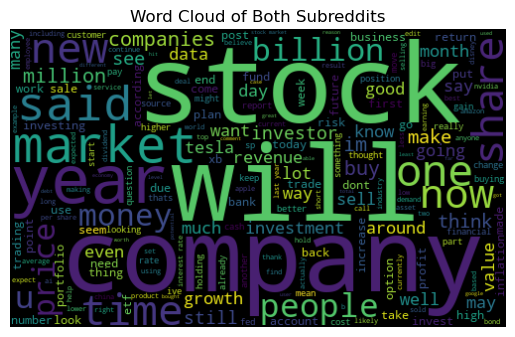

In [10]:
#Plot Word Cloud
allWords = ' '.join([posts for posts in text_df['cleaned_text']])
wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Both Subreddits')
plt.savefig('../Images/word_cloud_1.png')
plt.show()

In [11]:
### Separate the data into groups
# Variable
groups = text_df.groupby('subreddit')

print(groups.size())

subreddit
investing    1998
stocks       1804
dtype: int64


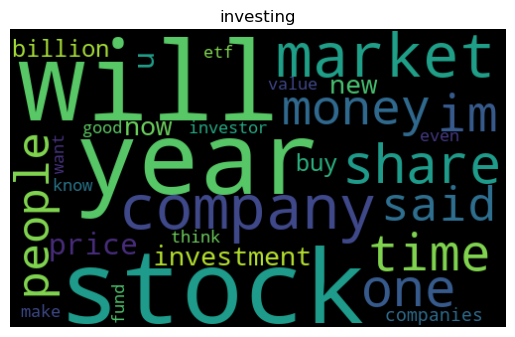

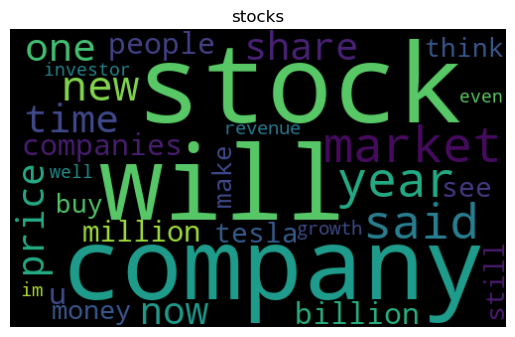

In [13]:
#Word Cloud for each group
for group in groups:
    allWords = ' '.join([posts for posts in group[1]['cleaned_text']])
    wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=110, max_words=30).generate(allWords)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(group[0])
    plt.savefig('../Images/word_cloud_in_st_2.png')
    plt.show()

In [14]:
#Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
text_df['Analysis'] = text_df['Polarity'].apply(getAnalysis) 

In [15]:
#Display Positive posts #Ref: www.youtube.com/watch?v=ujId4ipkBio (34:56)
j = 1
sortedDF = text_df.sort_values(by=['Polarity'])
sortedDF = sortedDF.reset_index(drop=True)
positive_count = 0

for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['cleaned_text'][i])
        print()
        j = j+1
        positive_count += 1
        if positive_count == 2:  # Break the loop after printing 10 positive posts
            break

1) in a rare companywide memo from cfo ruth porat google kicked off multiyear employee service cuts the company is cutting back on laptops and equipment according to more detailed internal documents viewed by cnbc in separate documents viewed by cnbc google said its cutting back on fitness classes staplers tape and the frequency of laptop replacements for employees

2) have been a td ameritrade customer for a few years got an email telling me that they are now changing me to schwab i would really like to hear what people that use schwab think about them good and bad is there anyone who has made the change already appreciate the feedback thank you



In [16]:
#Display Negative posts #Ref: www.youtube.com/watch?v=ujId4ipkBio (38:56)
j = 1
sortedDF = text_df.sort_values(by=['Polarity'], ascending=False)
sortedDF = sortedDF.reset_index(drop=True)
negative_count = 0
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+ sortedDF['cleaned_text'][i])
        print()
        j = j+1
        negative_count += 1
        if negative_count == 2:  # Break the loop after printing 10 negative posts
            break

1) at least two more democrats and a republican senator failed to report stock transactions last year as a ban on congressional stock trading flounders in a senate working group the deadline for members of congress to file their annual financial disclosures for was may but as usual most members availed themselves of a day extension that will give them until sometime in august to release their reports the disclosures list their household assets as well as other information like outside positions and travel reimbursements and are often dumped online as hundreds of pages of illegible paper scans in the senate just senators filed their annual disclosures by the deadline a review of this batch of disclosures shows that last year at least three more senators appear to have violated the stock acts requirement that they disclose certain financial transactions made by their households within days two senators democrats john hickenlooper of colorado and gary peters of michigan filed periodic tra

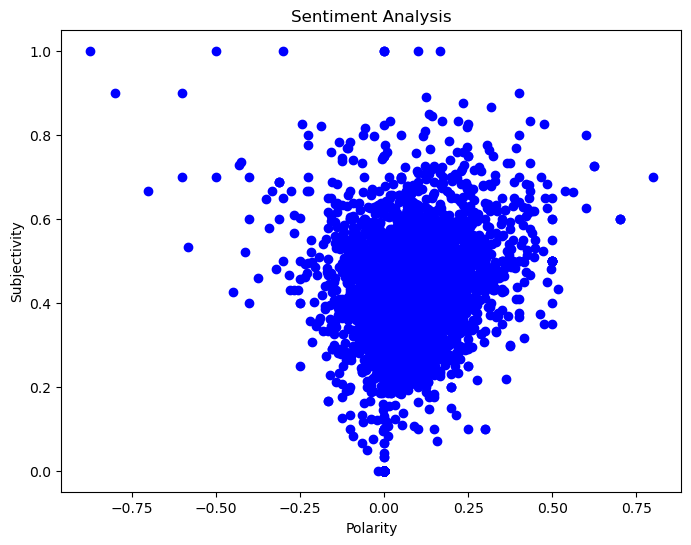

In [18]:
#Plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0, text_df.shape[0]):
    plt.scatter(text_df['Polarity'][i], text_df['Subjectivity'][i], color='Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.savefig('../Images/sentiment_analysis_1.png')
plt.show();

In [19]:
#Get the percentage of positive posts
positive_posts = text_df[text_df.Analysis == 'Positive']
positive_posts = positive_posts['cleaned_text']
round((positive_posts.shape[0] / text_df.shape[0]) * 100, 1)

76.7

In [20]:
# Get the percentage of negative posts
negative_posts = text_df[text_df.Analysis == 'Negative']
negative_posts = negative_posts['cleaned_text']
round((negative_posts.shape[0] / text_df.shape[0]) * 100, 1)

17.0

In [21]:
#Get the percentage of neutral posts
neutral_posts = text_df[text_df.Analysis == 'Neutral']
neutral_posts = neutral_posts['cleaned_text']
round((neutral_posts.shape[0] / text_df.shape[0]) * 100, 1)

6.3

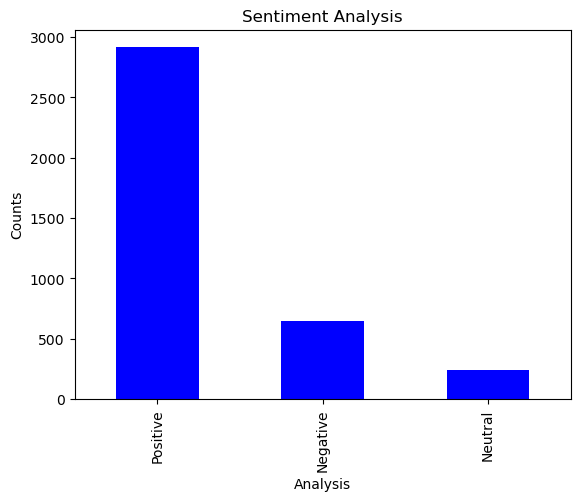

In [22]:
# Value Counts
text_df['Analysis'].value_counts()

#Plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
text_df['Analysis'].value_counts().plot(kind='bar', color='Blue')
plt.savefig('../Images/sentiment_analysis_2.png')
plt.show()

### Calculate the sentiment of each group

In [23]:
#using same for other subreddit, changing subreddit name
subreddit_names = ['stocks', 'investing']  
subreddit_dfs = {name: text_df[text_df['subreddit'] == name] for name in subreddit_names}

In [24]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

for subreddit, df in subreddit_dfs.items():
    df['Analysis'] = df['Polarity'].apply(getAnalysis)

/var/folders/hd/8z3slh4d16d2yvs205jh8smw0000gn/T/ipykernel_12676/2086667499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = df['Polarity'].apply(getAnalysis)
/var/folders/hd/8z3slh4d16d2yvs205jh8smw0000gn/T/ipykernel_12676/2086667499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = df['Polarity'].apply(getAnalysis)


## Stocks

361) this is a story that involves gme but it is not about gme the events im describing here happened on january in my cash retirement account in short i had some gme shares and used the interface to sell them immediately after i read that robinhood announced the disabling of their buy button a few minutes later it did not appear to work so i attempted to sell again subsequently my account showed that both sells went through then my account had the cash from both sales and a negative balance of shares that i was required to deliver in days after seeing the stock price dramatically rise and my apparent liabilities increasing without limit i freaked out and covered the short position at a huge loss k if i was lucky and the price went down i could have been able to cover the short at a huge gain and could have kept my mouth shut not that i would have but instead im out a bunch of money in my retirement account that was a result of this bug and schwab owes me about k had i not covered this

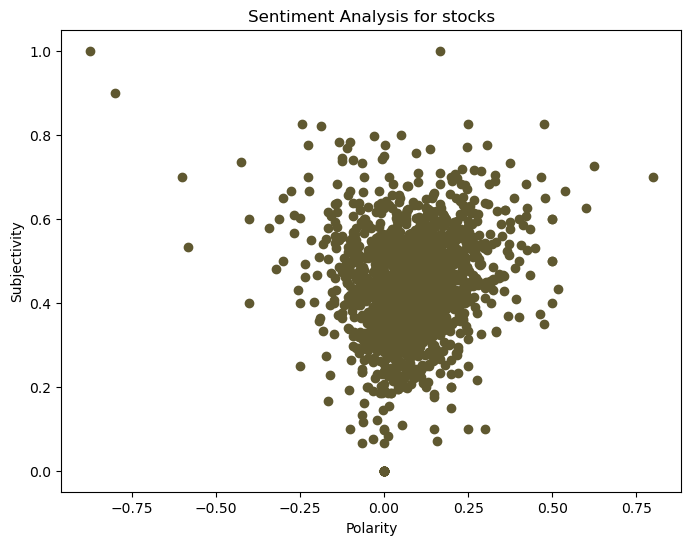

Positive Posts Percentage: 80.0%
Negative Posts Percentage: 18.2%
Neutral Posts Percentage: 1.8%


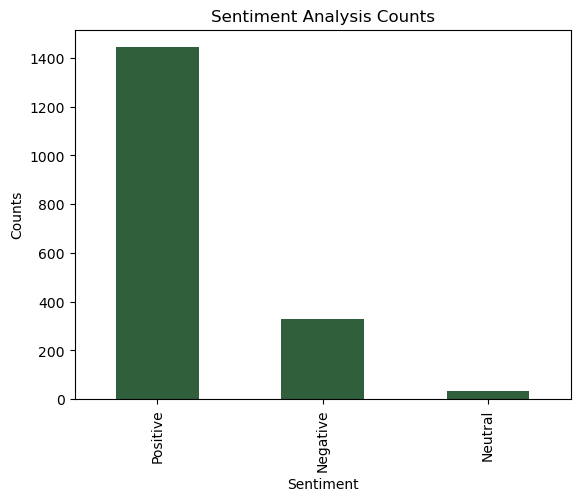

In [25]:
# Example for one subreddit
subreddit_name = 'stocks'  
df = subreddit_dfs[subreddit_name]

# Display Positive Posts
sortedDF = df.sort_values(by=['Polarity']).reset_index(drop=True)
positive_count = 0

for i, row in enumerate(sortedDF.itertuples(), 1):
    if row.Analysis == 'Positive':
        print(f"{i}) {row.cleaned_text}\n")
        positive_count += 1
        if positive_count == 5:
            break

# Plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df['Polarity'], df['Subjectivity'], color='#5f5830')
plt.title(f'Sentiment Analysis for {subreddit_name}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.savefig('../Images/sentiment_a_stocks.png')
plt.show()

# Calculate and Display Percentages
positive_percentage = (df[df.Analysis == 'Positive'].shape[0] / df.shape[0]) * 100
negative_percentage = (df[df.Analysis == 'Negative'].shape[0] / df.shape[0]) * 100
neutral_percentage = (df[df.Analysis == 'Neutral'].shape[0] / df.shape[0]) * 100
print(f"Positive Posts Percentage: {positive_percentage:.1f}%")
print(f"Negative Posts Percentage: {negative_percentage:.1f}%")
print(f"Neutral Posts Percentage: {neutral_percentage:.1f}%")

# Value Counts and Plot
df['Analysis'].value_counts().plot(kind='bar', title='Sentiment Analysis Counts', color='#305f3b')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.savefig('../Images/sentiment_counts_stocks.png')
plt.show()

## Investing

528) in a rare companywide memo from cfo ruth porat google kicked off multiyear employee service cuts the company is cutting back on laptops and equipment according to more detailed internal documents viewed by cnbc in separate documents viewed by cnbc google said its cutting back on fitness classes staplers tape and the frequency of laptop replacements for employees

529) have been a td ameritrade customer for a few years got an email telling me that they are now changing me to schwab i would really like to hear what people that use schwab think about them good and bad is there anyone who has made the change already appreciate the feedback thank you

530) this is all very bad for netflix and very good for disney no

531) the us economy suffered its worst period ever in the second quarter with gdp falling economists surveyed by dow jones were looking for a decline of the us economy saw the biggest plunge in activity it has ever known in the second quarter though it wasnt quite as bad a

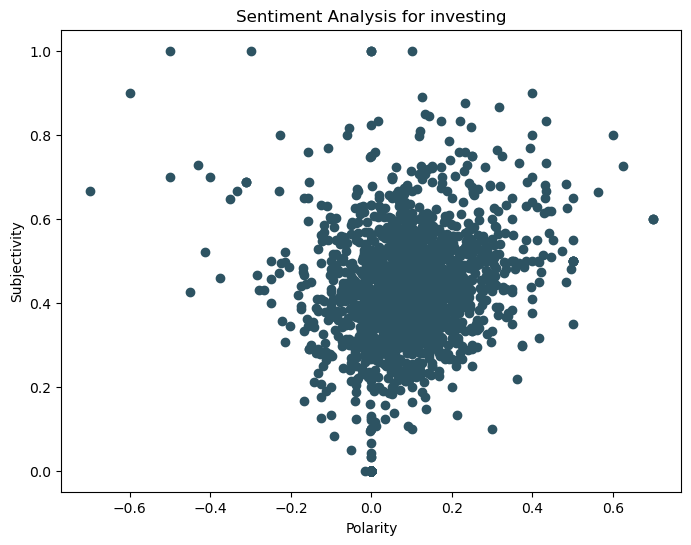

Positive Posts Percentage: 73.6%
Negative Posts Percentage: 16.0%
Neutral Posts Percentage: 10.4%


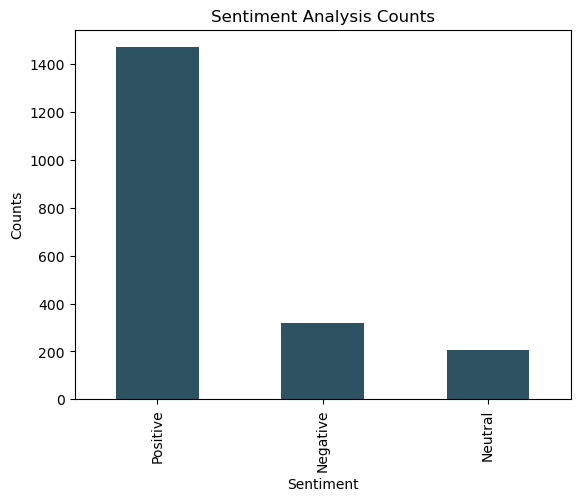

In [26]:
# Subreddit 
subreddit_name = 'investing' # Replace with subreddit name
df = subreddit_dfs[subreddit_name]

# Display Positive Posts
sortedDF = df.sort_values(by=['Polarity']).reset_index(drop=True)
positive_count = 0

for i, row in enumerate(sortedDF.itertuples(), 1):
    if row.Analysis == 'Positive':
        print(f"{i}) {row.cleaned_text}\n")
        positive_count += 1
        if positive_count == 5:
            break

# Plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df['Polarity'], df['Subjectivity'], color='#2d5362')
plt.title(f'Sentiment Analysis for {subreddit_name}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.savefig('../Images/sentiment_a_investing.png')
plt.show()

# Calculate and Display Percentages
positive_percentage = (df[df.Analysis == 'Positive'].shape[0] / df.shape[0]) * 100
negative_percentage = (df[df.Analysis == 'Negative'].shape[0] / df.shape[0]) * 100
neutral_percentage = (df[df.Analysis == 'Neutral'].shape[0] / df.shape[0]) * 100
print(f"Positive Posts Percentage: {positive_percentage:.1f}%")
print(f"Negative Posts Percentage: {negative_percentage:.1f}%")
print(f"Neutral Posts Percentage: {neutral_percentage:.1f}%")

# Value Counts and Plot
df['Analysis'].value_counts().plot(kind='bar', title='Sentiment Analysis Counts', color='#2d5362')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.savefig('../Images/sentiment_counts_investing.png')
plt.show()

## BERT Tokenization

In [2]:
#Variables
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased') 
subreddit_sentiments = {}

def encode_text_for_bert(text, tokenizer, max_length=512):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,  
        max_length=max_length,   
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'      # Return numpy tensors
    )

for subreddit, group in tqdm(groups, desc="Processing subreddits"):
    group['encoded_texts'] = group['cleaned_text'].apply(lambda x: encode_text_for_bert(x, tokenizer))

    predictions = []

    for index, row in tqdm(group.iterrows(), total=group.shape[0], desc=f"Predicting for {subreddit}"):
        encoded_dict = row['encoded_texts']
        input_ids = np.array(encoded_dict['input_ids'])
        attention_mask = np.array(encoded_dict['attention_mask'])

        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = tf.nn.softmax(outputs.logits, axis=-1)
        predictions.append(prediction)
    
    # Aggregate the predictions for the current subreddit
    aggregated_prediction = tf.reduce_mean(tf.concat(predictions, axis=0), axis=0)
    subreddit_sentiments[subreddit] = aggregated_prediction.numpy()

# Convert the aggregated sentiments into a DataFrame
sentiment_df = pd.DataFrame.from_dict(subreddit_sentiments, orient='index', columns=['Confidence_Positive', 'Confidence_Negative'])

# Reset the index to make subreddit names a column
sentiment_df.reset_index(inplace=True)
sentiment_df.rename(columns={'index': 'Subreddit'}, inplace=True)

# Display the DataFrame
print(sentiment_df)

In [30]:
sentiment_df.to_csv('../Conclusion/reports/sentiment_data_3march.csv', index=False)